<a href="https://colab.research.google.com/github/JanMikicki/Quantum-task-4/blob/main/quantum_task4_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Most code taken from: 
https://keras.io/examples/vision/oxford_pets_image_segmentation/#what-does-one-input-image-and-corresponding-segmentation-mask-look-like
"""

In [1]:
import os

input_dir = "/content/drive/MyDrive/quantum/train_color"
target_dir = "/content/drive/MyDrive/quantum/train_masks"

img_size = (512, 512)
num_classes = 2
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 441
/content/drive/MyDrive/quantum/train_color/color0.png | /content/drive/MyDrive/quantum/train_masks/mask0.png
/content/drive/MyDrive/quantum/train_color/color1.png | /content/drive/MyDrive/quantum/train_masks/mask1.png
/content/drive/MyDrive/quantum/train_color/color10.png | /content/drive/MyDrive/quantum/train_masks/mask10.png
/content/drive/MyDrive/quantum/train_color/color100.png | /content/drive/MyDrive/quantum/train_masks/mask100.png
/content/drive/MyDrive/quantum/train_color/color101.png | /content/drive/MyDrive/quantum/train_masks/mask101.png
/content/drive/MyDrive/quantum/train_color/color102.png | /content/drive/MyDrive/quantum/train_masks/mask102.png
/content/drive/MyDrive/quantum/train_color/color103.png | /content/drive/MyDrive/quantum/train_masks/mask103.png
/content/drive/MyDrive/quantum/train_color/color104.png | /content/drive/MyDrive/quantum/train_masks/mask104.png
/content/drive/MyDrive/quantum/train_color/color105.png | /content/drive/MyDrive/qu

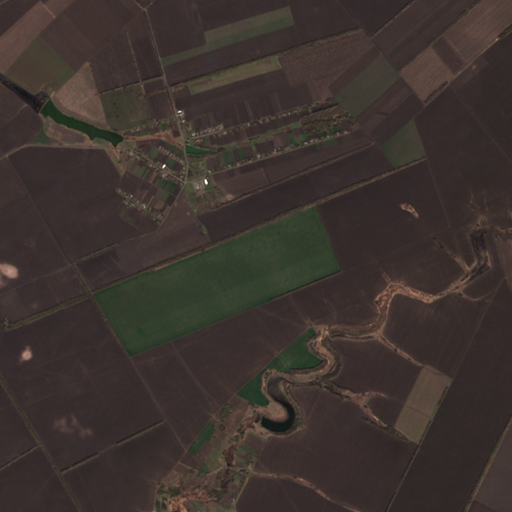

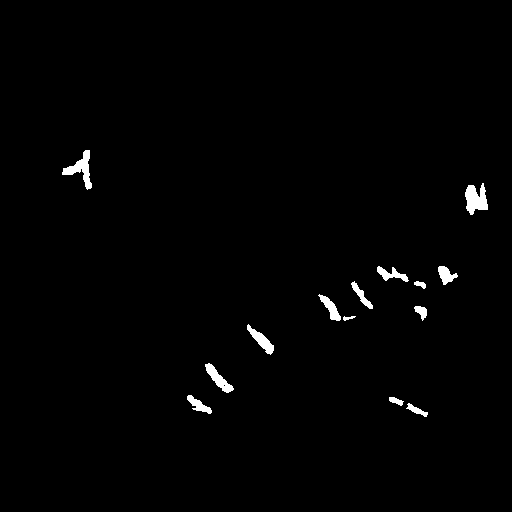

In [86]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[64]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[64]))
display(img)

In [3]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class SatelliteImages(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)           
            #y[j] -= 1
        return x, y

In [4]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
#model.summary()

In [5]:
import random

# Split our img paths into a training and a validation set
val_samples = 50
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SatelliteImages(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [6]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("corrosion_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
48/48 [==============================] - 84s 1s/step - loss: 0.1462 - val_loss: 0.0101
Epoch 2/15
48/48 [==============================] - 27s 569ms/step - loss: 0.0419 - val_loss: 0.0119
Epoch 3/15
48/48 [==============================] - 28s 575ms/step - loss: 0.0463 - val_loss: 0.0074
Epoch 4/15
48/48 [==============================] - 27s 561ms/step - loss: 0.0231 - val_loss: 0.0097
Epoch 5/15
48/48 [==============================] - 27s 565ms/step - loss: 0.0216 - val_loss: 0.0085
Epoch 6/15
48/48 [==============================] - 27s 566ms/step - loss: 0.0210 - val_loss: 0.0127
Epoch 7/15
48/48 [==============================] - 27s 562ms/step - loss: 0.0191 - val_loss: 0.0084
Epoch 8/15
48/48 [==============================] - 27s 562ms/step - loss: 0.0189 - val_loss: 0.0106
Epoch 9/15
48/48 [==============================] - 27s 567ms/step - loss: 0.0193 - val_loss: 0.0070
Epoch 10/15
48/48 [==============================] - 27s 569ms/step - loss: 0.0164 - val_loss:

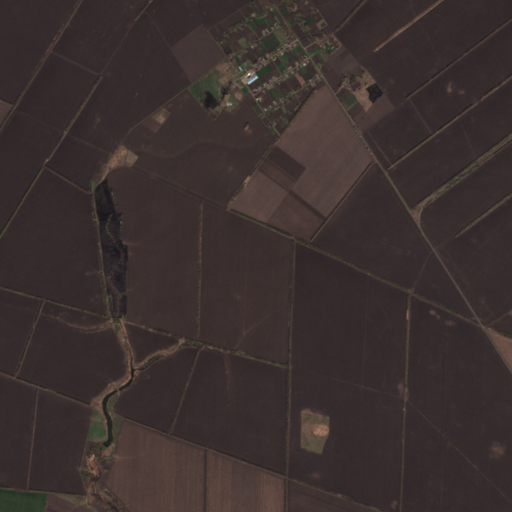

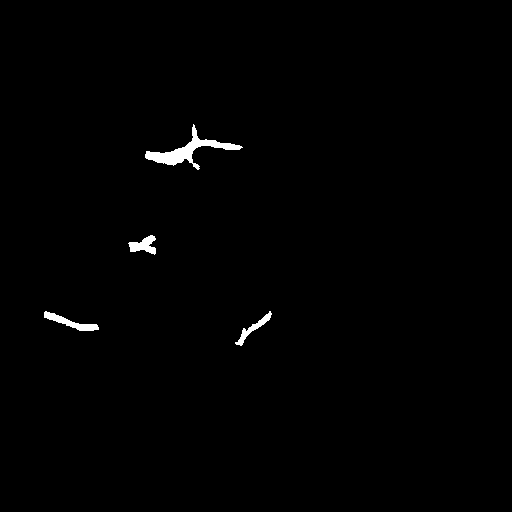

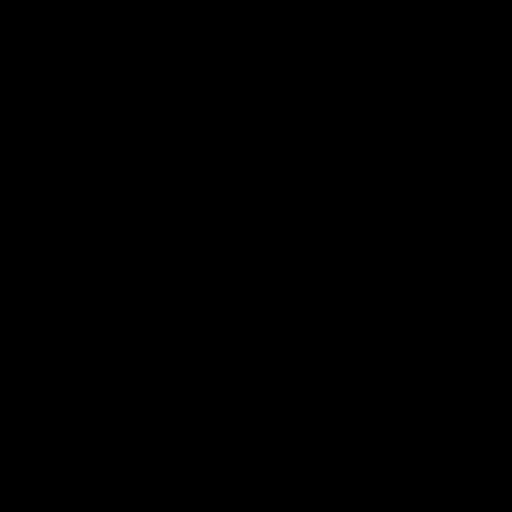

In [69]:
# Generate predictions for all images in the validation set

val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for i-th validation image
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [ ]:
# Predict satellite tiles in order
preds = []

for image in os.listdir("/content/drive/MyDrive/quantum/train_color/"):

    inp = load_img("/content/drive/MyDrive/quantum/train_color/" + image)
    inp = np.array(inp)
    inp = np.expand_dims(inp, axis=0)
    pred = model.predict(inp)
    mask = np.argmax(pred, axis=-1)
    mask = np.expand_dims(mask, axis=-1)    # (1, 512, 512, 1)
    mask = np.squeeze(mask, axis=0)
    preds.append(mask)


In [ ]:
# Glue predictions together

tileSize = 512

y = np.zeros((10752, 10752, 1), dtype="uint8")

cnt = 0
for i in range(21):
    for j in range(21):
        y[i*tileSize:i*tileSize + tileSize,
          j*tileSize:j*tileSize + tileSize] = preds[cnt]

        cnt += 1

img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(y))
display(img)

In [57]:
# Predicted only black pixels :(
unique, counts = np.unique(img, return_counts=True)
dict(zip(unique, counts))

{0: 115605504}